# Wine Price Prediction Analysis 
## MSCA 31008

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from scipy import stats, integrate
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data')

#### EDA and Feature Engineering:

In [16]:
wine = pd.read_csv('clean_wine_dataset.csv')

In [17]:
wine

,description,designation,points,price,province,variety,winery
0,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Sauvignon Blanc,Macauley
1,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Pinot Noir,Ponzi
2,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Provence red blend,Domaine de la Bégude
3,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Tinta de Toro,Numanthia
4,Slightly gritty black-fruit aromas include a s...,San Román,95,65.0,Northern Spain,Tinta de Toro,Maurodos
...,...,...,...,...,...,...,...
152256,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
152257,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Pinot Noir,Citation
152258,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Gewürztraminer,Domaine Gresser
152259,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Pinot Gris,Domaine Marcel Deiss


In [18]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152261 entries, 0 to 152260
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  152261 non-null  object 
 1   designation  106521 non-null  object 
 2   points       152261 non-null  int64  
 3   price        152261 non-null  float64
 4   province     152261 non-null  object 
 5   variety      152261 non-null  object 
 6   winery       152261 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 8.1+ MB


In [19]:
wine["points"].describe()

count    152261.000000
mean         88.061651
std           3.061179
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

In [20]:
wine.groupby(['province']).mean().sort_values(by = 'points',ascending = False)

,points,price
province,,
Südburgenland,94.000000,57.000000
Martinborough Terrace,93.000000,60.000000
Mittelrhein,92.250000,30.500000
England,91.766667,52.633333
Santa Cruz,91.500000,77.500000
...,...,...
Lake Skadar Valley,82.000000,10.000000
Jiri Valley,81.500000,13.500000
Chisinau County,81.000000,9.000000


In [21]:
wine.groupby(['variety']).mean().sort_values(by = 'points',ascending = False)

,points,price
variety,,
Gelber Traminer,95.000000,35.0
Tinta del Pais,95.000000,47.5
Riesling-Chardonnay,94.000000,40.0
Blauburgunder,93.000000,19.0
Garnacha-Cariñena,93.000000,57.0
...,...,...
Chardonelle,82.000000,30.0
Aidani,82.000000,27.0
Airen,81.666667,9.0


In [22]:
def sentiment_label(x):
    if x <= 83:
        return 'negative'
    elif x>= 90:
        return 'positive'
    else:
        return 'neutral'

def sentiment_score(x):
    if x <= 83:
        return 0
    elif x>= 90:
        return 1
    else:
        return 2

In [23]:
wine['sentiment_score'] = wine.points.apply(lambda x: sentiment_score(x))

In [24]:
wine['sentiment_label'] = wine.points.apply(lambda x: sentiment_label(x))

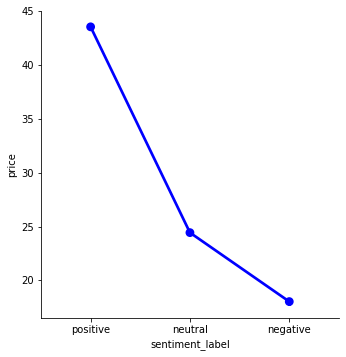

In [25]:
h = sns.PairGrid(data=wine, x_vars=['sentiment_label'], y_vars='price', size=5)
h.map(sns.pointplot, color="Blue")

In [26]:
wine.groupby(['sentiment_label']).mean()

,points,price,sentiment_score
sentiment_label,,,
negative,82.218302,18.028066,0.0
neutral,86.780279,24.432057,2.0
positive,91.461774,43.542980,1.0


In [28]:
todummies = ['province','variety']
dummies = pd.get_dummies(wine[todummies])
winetrain = pd.concat([dummies,wine],axis=1)

In [29]:
winetrain = winetrain.drop(['designation'], axis=1)
winetrain = winetrain.drop(['province'], axis=1)
winetrain = winetrain.drop(['variety'], axis=1)
winetrain = winetrain.drop(['winery'], axis=1)
winetrain = winetrain.drop(['sentiment_label'], axis=1)

In [22]:
winetrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152261 entries, 0 to 152260
Columns: 1221 entries, province_Achaia to sentiment_score
dtypes: float64(1), int64(2), object(1), uint8(1217)
memory usage: 181.4+ MB


In [23]:
winetrain = winetrain.drop(['description'], axis=1)

In [24]:
winetrain["price"].describe()

count    152261.000000
mean         30.474961
std          19.145138
min           4.000000
25%          16.000000
50%          25.000000
75%          40.000000
max         100.000000
Name: price, dtype: float64

In [25]:
def Price_Range(x):
    if x <= 16:
        return 'Cheap'
    elif x>= 40:
        return 'Expensive'
    else:
        return 'Midrange'

def Price_Range_Score(x):
    if x <= 16:
        return 0
    elif x>= 40:
        return 1
    else:
        return 2

In [26]:
winetrain['Price_Range'] = winetrain.price.apply(lambda x: Price_Range_Score(x))

### Fitting Preliminary Models: 

In [ ]:
WineTrain = winetrain.copy()
WineTrain = WineTrain.drop(['price'],axis=1)

In [ ]:
X,y=WineTrain.drop(['Price_Range'],axis=1),WineTrain['Price_Range']

In [ ]:
train_X, val_X, train_y, val_y=train_test_split(X,y, train_size=(.8))

In [44]:
def pfa_first_classifier(model):
    classifier = model()
    classifier.fit(train_X, train_y)
    print(classifier.score(val_X, val_y))
    return classifier

#### Logistic Regression: 

In [ ]:
logisticregression = pfa_first_classifier(LogisticRegression)

acc_log_reg = round( logisticregression.score(val_X, val_y) * 100, 2)
print (str(acc_log_reg) + ' percent')

0.5821429744195974
58.21 percent


#### Decision Tree:

In [ ]:
decisiontree = pfa_first_classifier(DecisionTreeClassifier)

acc_decision_tree = round(decisiontree.score(val_X, val_y) * 100, 2)
print(round(acc_decision_tree,2,), ' percent')

0.6580304075132171
65.8  percent


#### Random Forest:

In [45]:
forest = pfa_first_classifier(RandomForestClassifier)

acc_random_forest = round(forest.score(val_X, val_y) * 100, 2)
print(round(acc_random_forest,2,), ' percent')

0.6671263914885233
66.71  percent


#### KNeighbors Classifier:

In [ ]:
KNN = pfa_first_classifier(KNeighborsClassifier)

acc_KNN = round(KNN.score(val_X, val_y) * 100, 2)
print(round(acc_KNN,2,), ' percent')

0.6257511575214265
62.58  percent


#### Linear SVC: 

In [ ]:
SVC = pfa_first_classifier(LinearSVC)
acc_linear_svc = round( SVC.score(val_X, val_y) * 100, 2)
print (str(acc_linear_svc) + ' percent')

0.42760975930121825
42.76 percent


#### Naive Bayes Via GaussianNB: 

In [ ]:
gnb = pfa_first_classifier(GaussianNB)

acc_gnb = round(gnb.score(val_X, val_y) * 100, 2)
print(round(acc_gnb,2,), ' percent')

0.3322496962532427
33.22  percent


#### Perceptron:

In [ ]:
perceptronmodel = pfa_first_classifier(Perceptron)

acc_perceptron = round(perceptronmodel.score(val_X, val_y) * 100, 2)
print(round(acc_perceptron,2,), ' percent')

0.5944241946606246
59.44  percent


#### SGD Classifier:

In [ ]:
sgdmodel = pfa_first_classifier(SGDClassifier)

acc_sgd = round(sgdmodel.score(val_X, val_y) * 100, 2)
print(round(acc_sgd,2,), ' percent')

0.5181427117196992
51.81  percent


In [ ]:
y_pred = forest.predict(val_X)

mse_forest = MSE(val_y, y_pred)

rmse_forest = mse_forest**(1/2)

print("Test set RMSE of the forest model is: {:.2f}".format(rmse_forest))

Test set RMSE of the forest model is: 0.92


In [ ]:
MSE_CV_scores = - cross_val_score(forest, train_X, train_y, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

RMSE_CV = (MSE_CV_scores.mean())**(1/2)

print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 0.92


#### Selecting Hyperparameters Via Randomized Search CV: 

In [ ]:
forest_2 = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

RandomForestCV = RandomizedSearchCV(forest_2, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

RandomForestCV.fit(train_X, train_y)
RandomForestCV.best_params_



Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [ ]:
rs_df = pd.DataFrame(RandomForestCV.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,600,23,2,sqrt,15,False,0.577860,1
1,100,2,18,sqrt,15,False,0.573173,2
2,400,23,2,sqrt,14,False,0.571071,3
3,700,12,2,sqrt,13,False,0.559306,4
4,100,50,39,sqrt,15,False,0.557139,5
5,800,28,12,sqrt,14,True,0.555899,6
6,600,50,23,sqrt,14,False,0.555259,7
7,1000,34,23,sqrt,14,True,0.554939,8
8,300,18,18,sqrt,13,True,0.548347,9
9,500,12,18,sqrt,13,False,0.547156,10


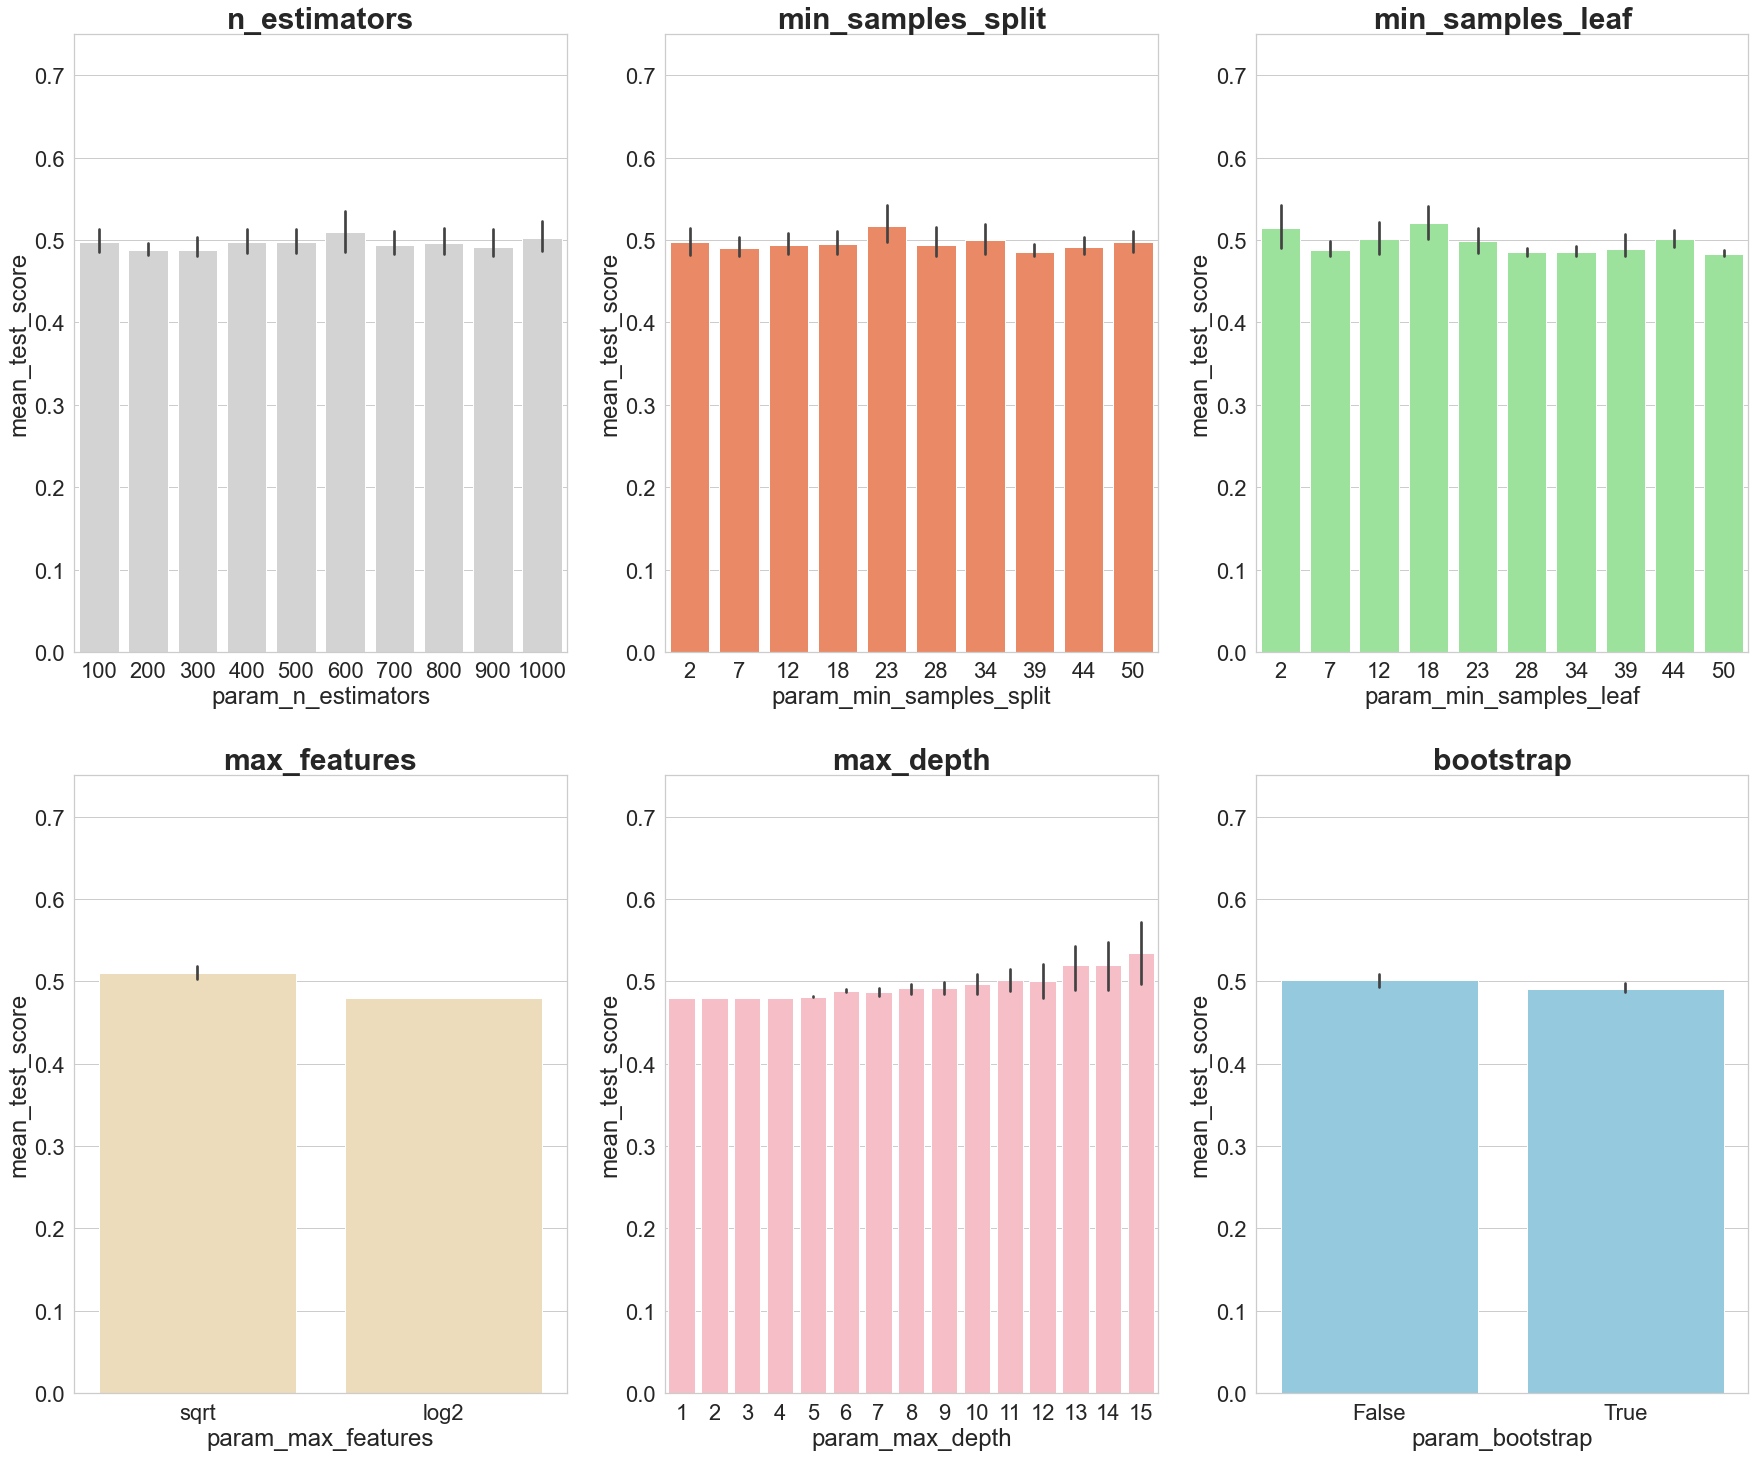

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2)

sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([0,.75])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([0,.75])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([0,.75])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([0,.75])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([0,.75])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([0,.75])

axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

plt.show()

#### Selecting Hyperparameters Via Grid Search CV:

In [ ]:
n_estimators = [300,500,700]
max_features = ['sqrt']
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(forest_2, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(train_X, train_y)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 700}

In [ ]:
rf3 = gs.best_estimator_.fit(train_X, train_y)


y_pred = gs.best_estimator_.predict(val_X)
y_pred_train=gs.best_estimator_.predict(train_X)

rmse_test = MSE(val_y, y_pred)**(1/2)
rmse_train = MSE(train_y, y_pred_train)**(1/2)

print('Test set RMSE: {:.2f}'.format(rmse_test))
print('Train set RMSE: {:.2f}'.format(rmse_train))

MSE_CV_scores = - cross_val_score(rf3, train_X, train_y, cv=3, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

RMSE_CV = (MSE_CV_scores.mean())**(1/2)

print('CV RMSE is: {:.2f}'.format(RMSE_CV))
acc_random_forest_gs = round(rf3.score(val_X, val_y) * 100, 2)
print(round(acc_random_forest_gs,2,), ' percent')

Test set RMSE: 1.04
Train set RMSE: 1.04
CV RMSE is: 1.05
58.03  percent


#### Ensemble: 

In [ ]:
gb = GradientBoostingClassifier()

gb.fit(train_X, train_y)

y_pred_Gboost = gb.predict(val_X)

y_pred_train=gb.predict(train_X)

rmse_test = MSE(val_y, y_pred_Gboost)**(1/2)
rmse_train = MSE(train_y, y_pred_train)**(1/2)


print('Test set RMSE of gb: {:.2f}'.format(rmse_test))
print('Train set RMSE of gb: {:.2f}'.format(rmse_train))

acc_GradientBoostingClassifier = round(gb.score(val_X, val_y) * 100, 2)
print(round(acc_GradientBoostingClassifier,2,), ' percent')

Test set RMSE of gb: 0.95
Train set RMSE of gb: 0.95
64.29  percent


In [ ]:
gb = GradientBoostingClassifier(random_state=1)

rf = RandomForestClassifier(random_state=1)

dt = DecisionTreeClassifier(random_state=1)

Classifiers = [('Gradient Boosting Classifier', gb), ('Decision Tree Classifier', dt),('Random Forest Classifier',rf)]

In [ ]:
vc = VotingClassifier(estimators=Classifiers)     

vc.fit(train_X, train_y)   

y_pred = vc.predict(val_X)

y_pred_train=vc.predict(train_X)

rmse_test = MSE(val_y, y_pred)**(1/2)
rmse_train = MSE(train_y, y_pred_train)**(1/2)


print('Test set RMSE of VC: {:.2f}'.format(rmse_test))
print('Train set RMSE of VC: {:.2f}'.format(rmse_train))

acc_VotingClassifier = round(vc.score(val_X, val_y) * 100, 2)
print('Voting Regressor:',round(acc_VotingClassifier,2,), ' percent')

Test set RMSE of VC: 0.92
Train set RMSE of VC: 0.84
Voting Regressor: 66.19  percent


In [ ]:
KNN = KNeighborsClassifier()

rf = RandomForestClassifier(random_state=1)

dt = DecisionTreeClassifier(random_state=1)

Classifiers = [('KNeighborsClassifier', KNN), ('Decision Tree Classifier', dt),('Random Forest Classifier',rf)]

In [ ]:
vc = VotingClassifier(estimators=Classifiers)     

vc.fit(train_X, train_y)   

y_pred = vc.predict(val_X)

y_pred_train=vc.predict(train_X)

rmse_test = MSE(val_y, y_pred)**(1/2)
rmse_train = MSE(train_y, y_pred_train)**(1/2)


print('Test set RMSE of VC: {:.2f}'.format(rmse_test))
print('Train set RMSE of VC: {:.2f}'.format(rmse_train))

acc_VotingClassifier2 = round(vc.score(val_X, val_y) * 100, 2)
print('Voting Regressor:',round(acc_VotingClassifier2,2,), ' percent')

Test set RMSE of VC: 0.92
Train set RMSE of VC: 0.84
Voting Regressor: 66.23  percent


In [ ]:
regr = AdaBoostClassifier(random_state=0, n_estimators=100)

regr.fit(train_X, train_y)

y_pred = regr.predict(val_X)

y_pred_train=regr.predict(train_X)

rmse_test = MSE(val_y, y_pred)**(1/2)
rmse_train = MSE(train_y, y_pred_train)**(1/2)

print('Test set RMSE of VC: {:.2f}'.format(rmse_test))
print('Train set RMSE of VC: {:.2f}'.format(rmse_train))

acc_AdaBoostClassifier = round(regr.score(val_X, val_y) * 100, 2)
print('Voting Regressor:',round(acc_AdaBoostClassifier,2,), ' percent')

Test set RMSE of VC: 0.96
Train set RMSE of VC: 0.95
Voting Regressor: 64.09  percent


#### Model Comparison:

In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree Classifier','Random Forest Classifier','KNeighbors Classifier','SVC','Naive Bayes Via GaussianNB','Perceptron','SGD','Random Forest GridSearchCV','Gradient Boosting Classifier','VotingRegressor (Logistic Regression, Decision Tree and Random Forest)','VotingRegressor (KNN, Decision Tree and Random Forest)','AdaBoost Classifier'],
    
    'Score': [acc_log_reg, acc_decision_tree,acc_random_forest,acc_KNN,acc_linear_svc,acc_gnb,acc_perceptron,acc_sgd,acc_random_forest_gs,acc_GradientBoostingClassifier,acc_VotingClassifier,acc_VotingClassifier2,acc_AdaBoostClassifier]
    })

models.sort_values(by='Score', ascending=False)
models['Score'] = pd.Series(["{0:.2f}%".format(val) for val in models['Score']], index = models.index)
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest Classifier,66.27%
11,"VotingRegressor (KNN, Decision Tree and Random...",66.23%
10,"VotingRegressor (Logistic Regression, Decision...",66.19%
1,Decision Tree Classifier,65.80%
9,Gradient Boosting Classifier,64.29%
12,AdaBoost Classifier,64.09%
3,KNeighbors Classifier,62.58%
6,Perceptron,59.44%
0,Logistic Regression,58.21%
8,Random Forest GridSearchCV,58.03%


#### Unbalanced Data! As such, we use SMOTE to properly sample from balanced classes: 

In [27]:
winetrain['Price_Range'].value_counts()/len(winetrain['Price_Range'])

2    0.480084
0    0.259962
1    0.259955
Name: Price_Range, dtype: float64

In [28]:
WineTrain_ = winetrain.copy()
WineTrain_ = WineTrain_.drop(['price'],axis=1)
X,y = WineTrain_.drop(['Price_Range'],axis=1),WineTrain_['Price_Range']
train_X, val_X, train_y, val_y=train_test_split(X,y, train_size=(.8))

In [31]:
method = SMOTE(kind='regular')

train_X_resampled, train_y_resampled = method.fit_sample(train_X, train_y)

In [35]:
np.bincount(train_y_resampled)

array([58486, 58486, 58486])

In [36]:
def resampleclassifier(model):
    classifier = model()
    classifier.fit(train_X_resampled, train_y_resampled)
    print(classifier.score(val_X, val_y))
    return classifier

In [38]:
LogisticRegression_Resampled = resampleclassifier(LogisticRegression)

acc_LogisticRegression_Resampled = round(LogisticRegression_Resampled.score(val_X, val_y) * 100, 2)
print(round(acc_LogisticRegression_Resampled,2,), ' percent')


0.5320986438117755
53.21  percent


In [37]:
forest_Resampled = resampleclassifier(RandomForestClassifier)

acc_random_forest_Resampled = round(forest_Resampled.score(val_X, val_y) * 100, 2)
print(round(acc_random_forest_Resampled,2,), ' percent')

0.6301185433290645
63.01  percent


In [46]:
#Pre-resample
predicted = forest.predict(val_X)

print('Classification report:\n', metrics.classification_report(val_y, predicted))
conf_mat = metrics.confusion_matrix(y_true=val_y, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.59      0.64      7927
           1       0.71      0.61      0.66      7914
           2       0.64      0.74      0.68     14612

    accuracy                           0.67     30453
   macro avg       0.68      0.65      0.66     30453
weighted avg       0.67      0.67      0.67     30453

Confusion matrix:
 [[ 4705    85  3137]
 [  152  4850  2912]
 [ 1996  1855 10761]]


In [42]:
#Resampled 
predicted = forest_Resampled.predict(val_X)

print('Classification report:\n', metrics.classification_report(val_y, predicted))
conf_mat = metrics.confusion_matrix(y_true=val_y, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.59      0.74      0.66      7927
           1       0.61      0.74      0.67      7914
           2       0.68      0.51      0.59     14612

    accuracy                           0.63     30453
   macro avg       0.63      0.66      0.64     30453
weighted avg       0.64      0.63      0.63     30453

Confusion matrix:
 [[5856  310 1761]
 [ 366 5868 1680]
 [3694 3453 7465]]


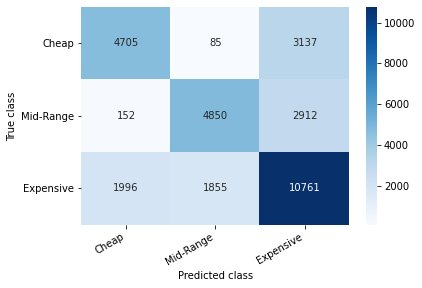

In [52]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

class_names = ["Cheap", "Mid-Range","Expensive"]
cm = metrics.confusion_matrix(y_true=val_y, y_pred=predicted)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [48]:
KNN = KNeighborsClassifier()

rf = RandomForestClassifier(random_state=1)

dt = DecisionTreeClassifier(random_state=1)

Classifiers = [('KNeighborsClassifier', KNN), ('Decision Tree Classifier', dt),('Random Forest Classifier',rf)]

vc = VotingClassifier(estimators=Classifiers)     

vc.fit(train_X_resampled, train_y_resampled)   

y_pred = vc.predict(val_X)

y_pred_train=vc.predict(train_X_resampled)

print('Classification report:\n', metrics.classification_report(val_y, y_pred))
conf_mat = metrics.confusion_matrix(y_true=val_y, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.58      0.75      0.65      7927
           1       0.61      0.74      0.67      7914
           2       0.69      0.50      0.58     14612

    accuracy                           0.63     30453
   macro avg       0.63      0.66      0.63     30453
weighted avg       0.64      0.63      0.62     30453

Confusion matrix:
 [[5906  306 1715]
 [ 408 5893 1613]
 [3798 3498 7316]]


In [62]:
gb = GradientBoostingClassifier()

gb.fit(train_X_resampled, train_y_resampled)

y_pred_Gboost = gb.predict(val_X)

y_pred_train=gb.predict(train_X_resampled)

rmse_test = MSE(val_y, y_pred_Gboost)**(1/2)
rmse_train = MSE(train_y_resampled, y_pred_train)**(1/2)


print('Test set RMSE of gb: {:.2f}'.format(rmse_test))
print('Train set RMSE of gb: {:.2f}'.format(rmse_train))

acc_GradientBoostingClassifier = round(gb.score(val_X, val_y) * 100, 2)
print(round(acc_GradientBoostingClassifier,2,), ' percent')

Test set RMSE of gb: 1.00
Train set RMSE of gb: 0.93
60.87  percent


In [61]:
regr = AdaBoostClassifier()

regr.fit(train_X_resampled, train_y_resampled)

y_pred = regr.predict(val_X)

y_pred_train=regr.predict(train_X_resampled)

rmse_test = MSE(val_y, y_pred)**(1/2)
rmse_train = MSE(train_y_resampled, y_pred_train)**(1/2)

print('Test set RMSE of VC: {:.2f}'.format(rmse_test))
print('Train set RMSE of VC: {:.2f}'.format(rmse_train))

acc_AdaBoostClassifier = round(regr.score(val_X, val_y) * 100, 2)
print('Voting Regressor:',round(acc_AdaBoostClassifier,2,), ' percent')

Test set RMSE of VC: 1.03
Train set RMSE of VC: 0.95
Voting Regressor: 59.06  percent


In [63]:
KNN = resampleclassifier(KNeighborsClassifier)

acc_KNN = round(KNN.score(val_X, val_y) * 100, 2)
print(round(acc_KNN,2,), ' percent')

0.5916330082422093
59.16  percent


Best Model: **forest_Resampled** as it has the highest accuracy based on balanced classes.

We began this analysis by first loading the required packages and the dataset, as cleaned via the EDA code provided in the attached preliminary workbook. We then explored the data to gain a better understanding of the relationships between a wine’s price and the other features in our dataset. Similar to our points prediction, we assigned sentiment scores to the wines. As shown, and consistent with preconceived expectations, the better the sentiments the more expensive the wine. We then assigned dummy variables to “province” and “variety” and dropped “designation” and “winery”. We chose these features as “province” and “variety” reflect the type of wine and location where the grapes for the wine were grown. We selected “province” and “variety” to test the notion that type of wine and location are two of the biggest features of a wine’s price.  We dropped “designation” and “winery” as “designation” was redundant with “variety” and “winery” was too specific to the point where many wineries from the training and test split only contributed one wine. As such, our model could not learn from or predict these wines. We then assigned the wines to one of three buckets: “Cheap” for wines under 16, “Mid-Range” for wines between 16 and 40, and “Expensive” for wines over 40.


We then split the data into test and train, dropping “Price_Range” as it is our target variable. We then also drop “price” as it is the basis for our target classes and therefore strongly correlated with “Price_Range” and including it would impair the validity of our analysis. As shown, we fit LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, KNeighborsClassifier, LinearSVC, Naive Bayes via GaussianNB, Perceptron, and SGDClassifier, of which RandomForestClassifier had the best fit with an accuracy, as measured by r-squared, of 66.71%. 


In an attempt to further our analysis, we fit hyperparameters via RandomSearchCV and GridSearchCV, in addition to ensemble models such as GradientBoostingClassifier, VotingClassifier (GradientBoostingClassifier, DecisionTreeClassifier, and RandomForestClassifier), VotingClassifier (KneighborsClassifier, DecisionTreeClassifier, and RandomForestClassifier) and AdaBoostClassifier. Of all of the alternative models we fit,  
GradientBoostingClassifier performed the best with an accuracy, as measured by r-squared, of 64.29% and test and train RMSEs of 0.95. 


After further exploring our data we realized that our target classes (i.e., “Price_Range”) were unbalanced as approximately 25% were “Cheap”, 25% “Mid-Range”, and 50% “Expensive”. As we wished to approach this classification problem properly, we leveraged the synthetic minority oversampling technique (“SMOTE”) to create balanced classes. As shown, after applying SMOTE to the training set, our target classes are equal with 58,586 records each. We then refit the models on the rebalanced training set and predicted on the imbalanced test set. We did not apply SMOTE to the full dataset as we did not want to predict classes for synthetically created data. 


As shown, RandomForestClassifier, fit on the resampled training data, performed the best with an accuracy score, as measured by r-squared, of approximately 63%. As r-squared is unable to account for the biases of our predictors, we feel that although the r-squared for the balanced data is marginally lower, it is correct to have fit the model on a balanced dataset rather than an imbalanced one for a marginal increase in accuracy. As such, we leveraged this model to predict our final classes for the test set. 
